### Install and Import Third Party Dependencies

In [1]:
%pip install pandas numpy matplotlib seaborn scipy

  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/ed/8c/87ddf1fcb55d11f9f847e3c69bb1c6f8e46e2f40ab1a2d2abadb2401b007/pandas-2.2.3-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for numpy from https://files.pythonhosted.org/packages/b9/c6/cd4298729826af9979c5f9ab02fcaa344b82621e7c49322cd2d210483d3f/numpy-2.2.3-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.8 kB ? eta -:--:--
     ------------------------------- ------ 51.2/60.8 kB 871.5 kB/s eta 0:00:01
     -------------------------------------- 60.8/60.8 kB 816.2 kB/s eta 0:00:00
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/14/cf/e382598f98be11bf51dd0bc60eca44a517f6793e3dc8b9d53634a144620c/matplotlib-3.10.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for seaborn from https://files.pyth

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

### Initialize datasets and columns for outlier detection

In [4]:
# Load dataset (update the file path if needed)
df = pd.read_csv("data.csv")

# Select numeric columns for outlier detection
numeric_cols = ["imdbAverageRating", "imdbNumVotes", "releaseYear"]
df_numeric = df[numeric_cols]

# Display dataset info and summary
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20877 entries, 0 to 20876
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               20225 non-null  object 
 1   type                20877 non-null  object 
 2   genres              20530 non-null  object 
 3   releaseYear         20842 non-null  float64
 4   imdbId              19356 non-null  object 
 5   imdbAverageRating   19166 non-null  float64
 6   imdbNumVotes        19166 non-null  float64
 7   availableCountries  166 non-null    object 
dtypes: float64(3), object(5)
memory usage: 1.3+ MB
None
        releaseYear  imdbAverageRating  imdbNumVotes
count  20842.000000       19166.000000  1.916600e+04
mean    2013.250744           6.395393  3.169231e+04
std       14.315295           1.094817  1.202100e+05
min     1913.000000           1.200000  5.000000e+00
25%     2012.000000           5.700000  3.262500e+02
50%     2018.000000        

### Outliers Detected using Z-score

In [8]:
z_scores = np.abs(zscore(df_numeric))
z_threshold = 3
outliers_z = (z_scores > z_threshold)
df_outliers_z = df[outliers_z.any(axis=1)]

print("\nOutliers detected using Z-score:")
print(df_outliers_z)


Outliers detected using Z-score:
Empty DataFrame
Columns: [title, type, genres, releaseYear, imdbId, imdbAverageRating, imdbNumVotes, availableCountries]
Index: []


### Outliers Detected using IQR

In [6]:
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = (df_numeric < lower_bound) | (df_numeric > upper_bound)
df_outliers_iqr = df[outliers_iqr.any(axis=1)]

print("\nOutliers detected using IQR:")
print(df_outliers_iqr)


Outliers detected using IQR:
                                   title   type                     genres  \
0                        American Beauty  movie                      Drama   
1                      The Fifth Element  movie  Action, Adventure, Sci-Fi   
2                      Kill Bill: Vol. 1  movie    Action, Crime, Thriller   
3                                Jarhead  movie      Biography, Drama, War   
4                             Unforgiven  movie             Drama, Western   
...                                  ...    ...                        ...   
20496        The Great Indian Kapil Show     tv          Comedy, Talk-Show   
20544                  Nobody Wants This     tv            Comedy, Romance   
20588               When the Phone Rings     tv    Drama, Mystery, Romance   
20729                               Polo     tv         Documentary, Sport   
20826  Das Boot - Die komplette TV-Serie     tv                 Drama, War   

       releaseYear      imdbId  i

### Data Visualization of Outlier

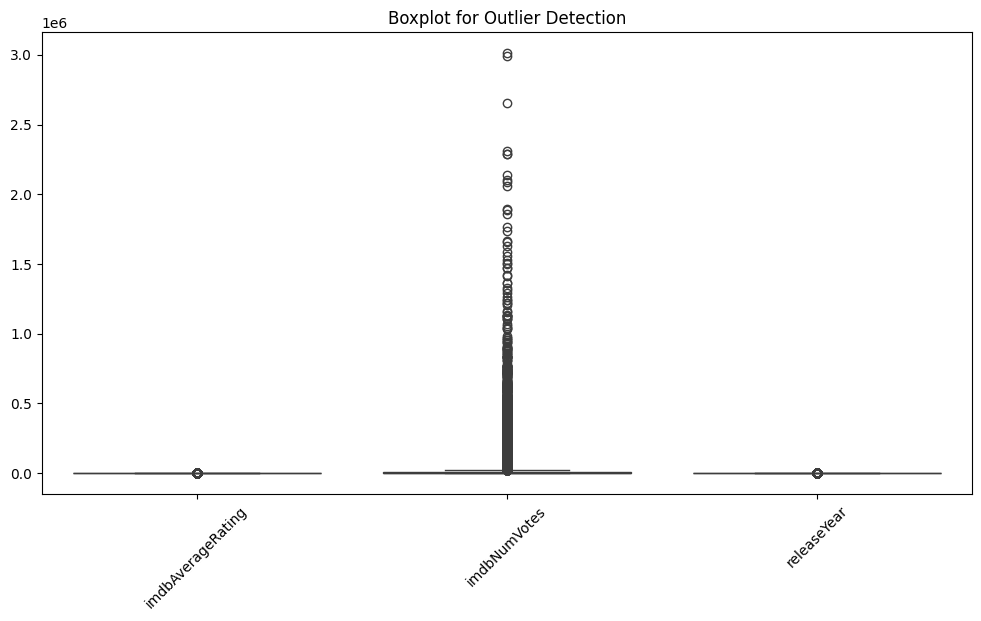

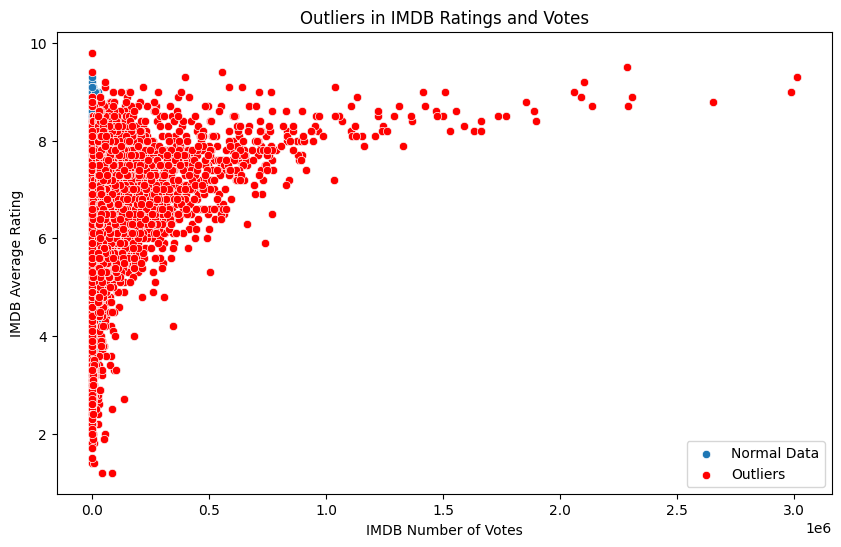

In [9]:
# Boxplot Visualization
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_numeric)
plt.xticks(rotation=45)
plt.title("Boxplot for Outlier Detection")
plt.show()

# Scatter Plot with Outliers Highlighted
outlier_indices = df_outliers_iqr.index
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df["imdbNumVotes"], y=df["imdbAverageRating"], label="Normal Data")
sns.scatterplot(x=df.loc[outlier_indices, "imdbNumVotes"], 
                y=df.loc[outlier_indices, "imdbAverageRating"], 
                color='red', label="Outliers")
plt.xlabel("IMDB Number of Votes")
plt.ylabel("IMDB Average Rating")
plt.legend()
plt.title("Outliers in IMDB Ratings and Votes")
plt.show()